# Setup

In [52]:
import seaborn as sns
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2 as cv
import math
from sklearn.metrics import confusion_matrix
import extract, train, evaluate
from img_display import roi_display_jup, plot_results_scan
from tcutil import Labels

In [53]:
folder_path = ""
image_file = "Test_crayon.png"
image_path = f"{folder_path}scan_resultsheets/Test/{image_file}"
print(image_path)

scan_resultsheets/Test/Test_crayon.png


# Extraction of symbols from scan picture

## Box detection

We use Boxdetection object from extract.py module, which contains all the functions needed to :
* rotate the scan
* detect the boxes
* align and reorder the boxes

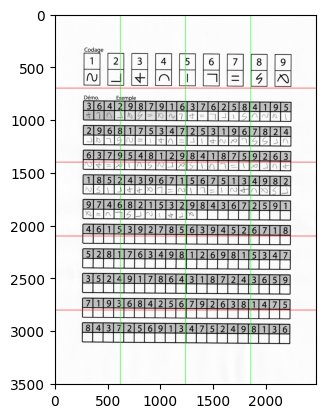

In [54]:
b = extract.Boxdetection(image_path = image_path)
plt.imshow(b.plot_scan(b.img))
plt.show()

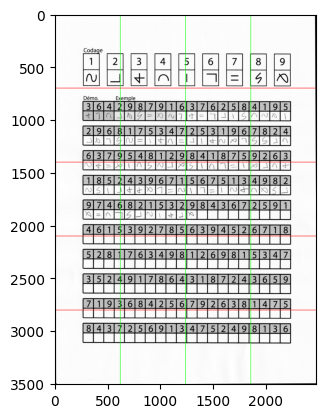

In [56]:
b.image_rotation(0.3)
plt.imshow(b.plot_scan(b.img_rot))

In [57]:
b.extract_boxes_fast()
print(b.box_coord.shape)

(400, 4)


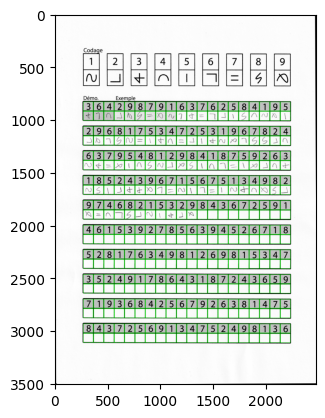

In [58]:
plt.imshow(b.plot_boxes(b.box_coord))

## Extraction of symbols (ROI) located inside the boxes

We use ROIExtract object from extract.py, which contains functions to extract pixels located inside box coordinate and store them in a numpy array.

The size of images to extract, as well as the indexes of box coordinate to use for symbol extraction, are hardcoded in ROIExtract.

We use visualisation function from img_display.py module.

In [59]:
r = extract.ROIExtract(b.img_rot)

In [60]:
r.extract_roi_symbols(b.box_coord)
print(r.roi_symbols.shape)

(200, 76, 82)


In [17]:
r.extract_roi_all(b.box_coord)
print(r.roi_all.shape)

(400, 76, 82)


In [61]:
l = Labels()

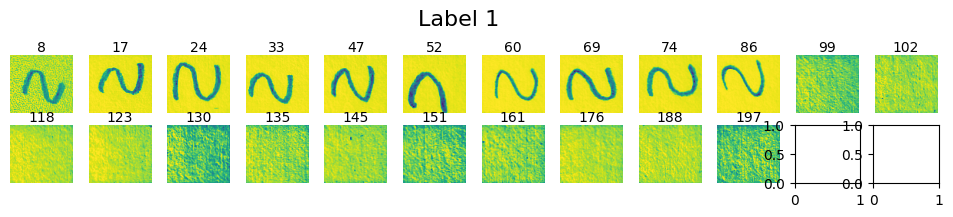

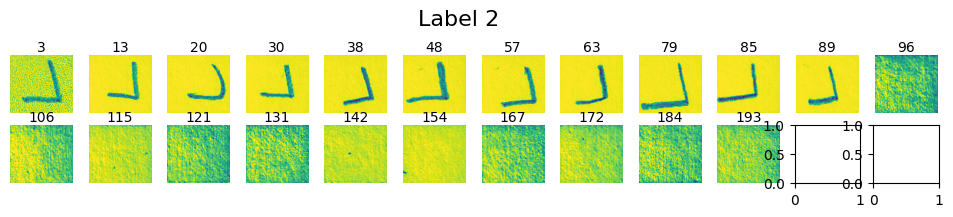

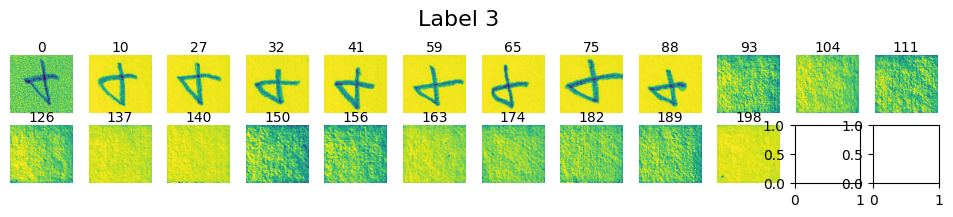

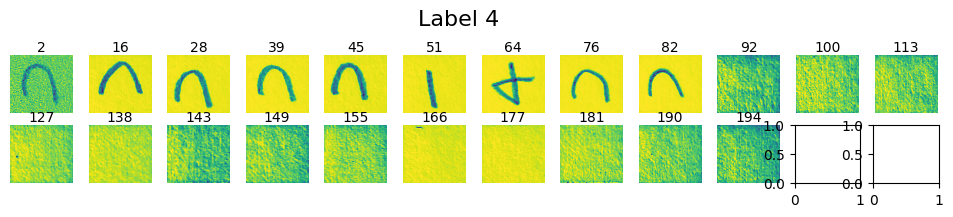

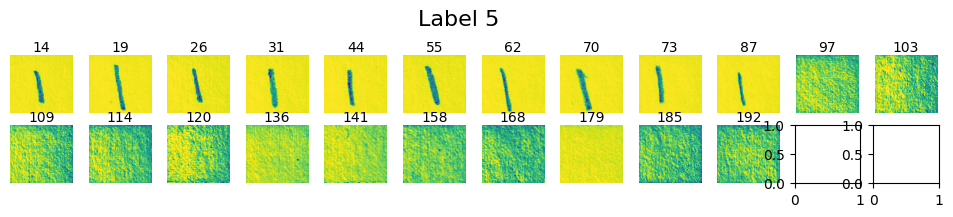

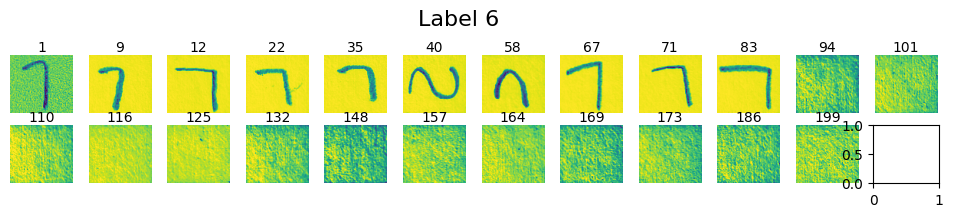

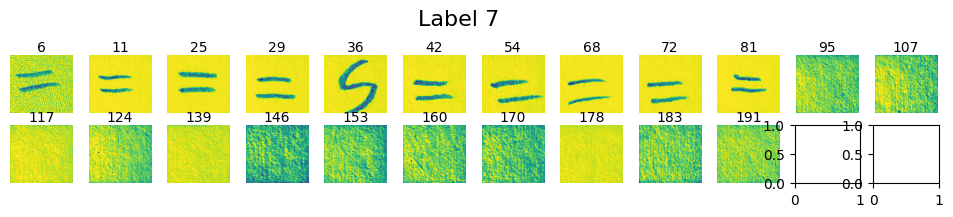

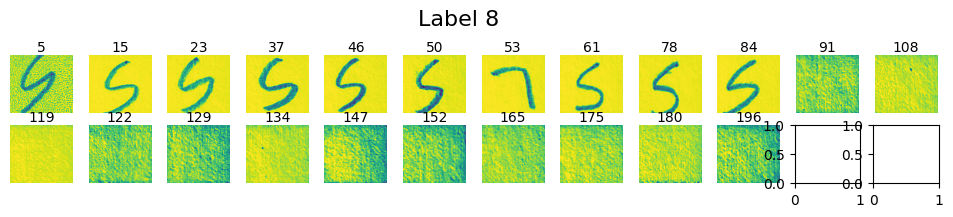

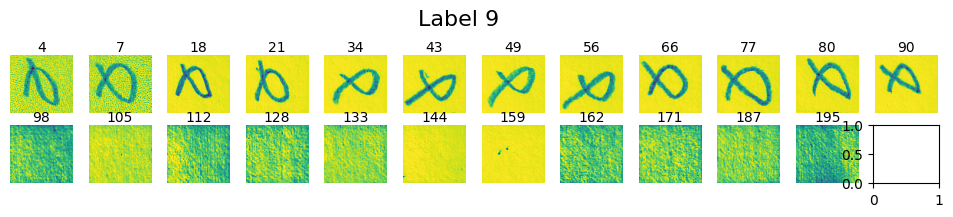

In [62]:
roi_display_jup(r.roi_symbols, l.labels["sheet_labels"])

### Attempt to detect empty ROI

In [63]:
roi = r.roi_symbols
print(roi.shape)

(200, 76, 82)


In [85]:
# 91 full et le reste empty
exemple = np.full((9,), 2)
full = np.full((82,), 1)
empty = np.full((109), 0)
l.labels["empty_box"] = np.hstack((exemple, full, empty))
print(l.labels["empty_box"])

[2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [83]:
roi_f = roi.reshape((200, 76*82))
print(roi_f.shape)

(200, 6232)


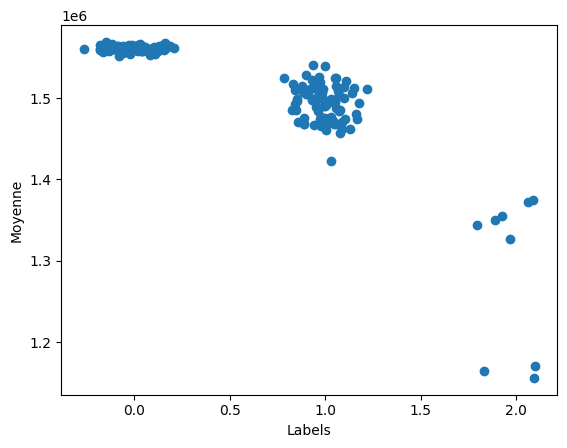

In [86]:
calc = roi_f.sum(axis=1)
labels = l.labels["empty_box"]
jitter = np.random.normal(0, 0.1, size=len(labels))
plt.plot(labels + jitter, calc, 'o')
plt.xlabel('Labels')
plt.ylabel('calculated metric')
plt.show()

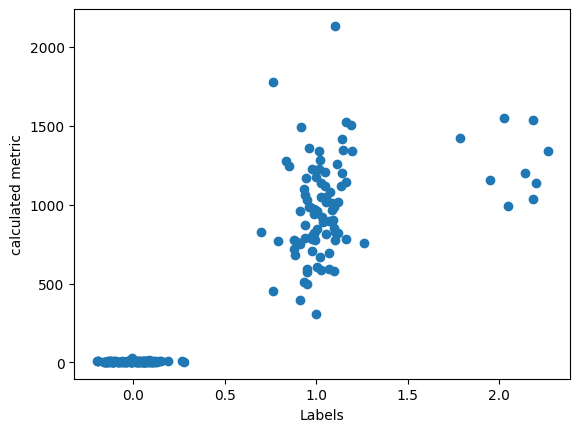

In [87]:
calc = roi_f.var(axis=1)
labels = l.labels["empty_box"]
jitter = np.random.normal(0, 0.1, size=len(labels))
plt.plot(labels + jitter, calc, 'o')
plt.xlabel('Labels')
plt.ylabel('calculated metric')
plt.show()

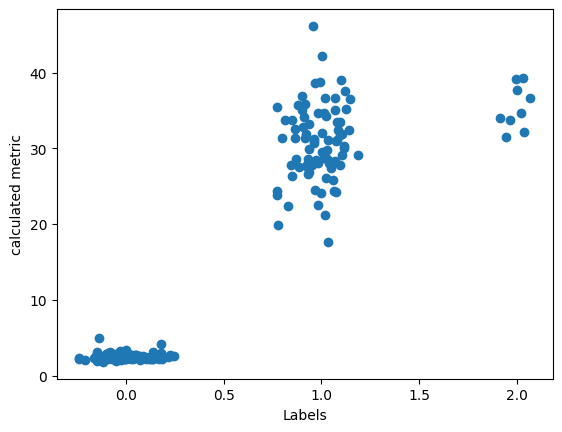

In [88]:
calc = roi_f.std(axis=1)
labels = l.labels["empty_box"]
jitter = np.random.normal(0, 0.1, size=len(labels))
plt.plot(labels + jitter, calc, 'o')
plt.xlabel('Labels')
plt.ylabel('calculated metric')
plt.show()

In [89]:
mask = calc > 10
print(mask)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

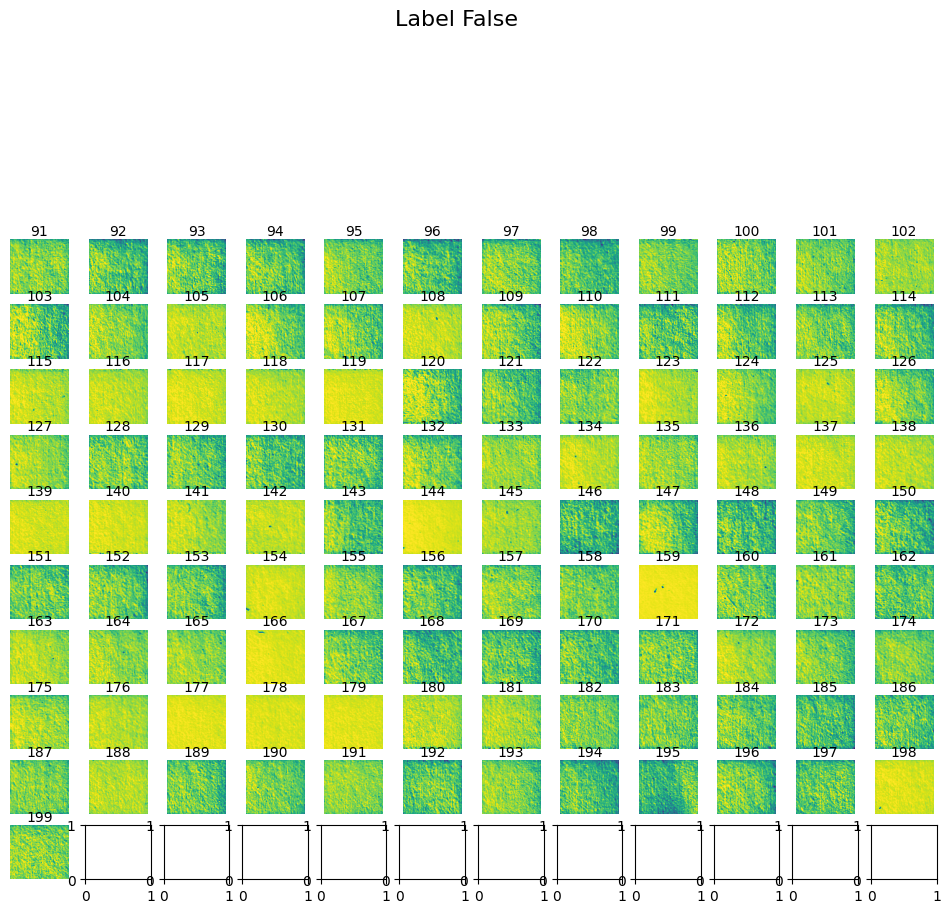

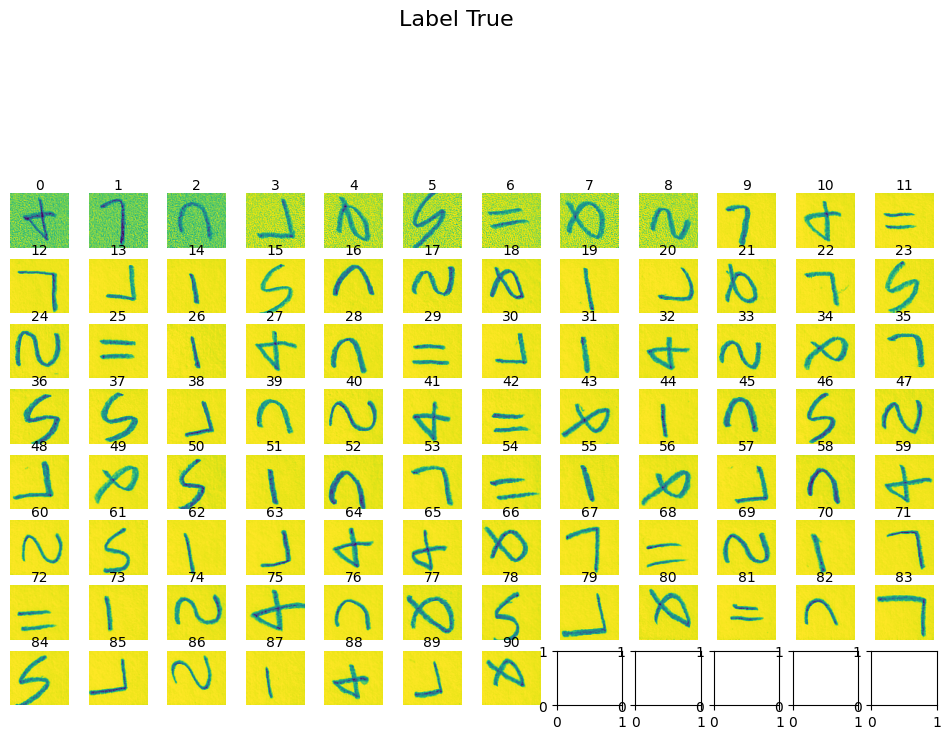

In [90]:
roi_display_jup(r.roi_symbols, mask)

# Correction

We will use Trainer and Evaluator objects (from train and evaluate), to perform following operations on image serie:
* redimension pictures (train)
* make prediction for labels using classification model (neural network)
* compare predictions with true labels to generate metrics

## Predictions

In [91]:
t = train.Trainer(r.roi_symbols)
print(t.pict_redim.shape)

(200, 28, 28)


In [92]:
e = evaluate.Evaluator(t.pict_redim)
l.labels['predicted_labels'] = e.predict('models/CNN_14-0.925_20240526.keras')
print(l.labels['predicted_labels'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
[3 9 9 2 9 8 7 9 1 0 3 7 6 2 5 8 4 1 0 5 2 0 6 8 1 7 5 3 4 7 2 5 3 1 0 6 8
 8 2 4 1 3 7 1 5 4 8 1 2 0 8 5 4 6 7 5 0 2 4 3 1 8 5 2 3 3 9 6 7 1 5 6 7 5
 1 3 4 9 8 2 9 7 4 6 8 2 0 5 3 2 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


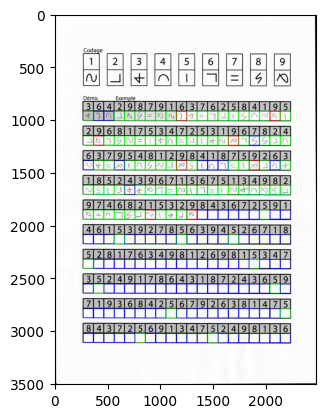

In [93]:
correct_scan = plot_results_scan(b.img_rot, l.labels['predicted_labels'], l.labels['sheet_labels'], b.box_coord)
plt.imshow(correct_scan)

## Metrics

In [44]:
# Manual correction of the resultsheet, used to assess model errors
# For Test.png
manual_labels = np.array([3, 6, 4, 2, 9, 8, 7, 9, 1, 6, 3, 7, 6, 2, 5, 8, 4, 1, 9, 5,
                        2, 9, 6, 8, 1, 7, 5, 3, 4, 7, 2, 5, 3, 1, 9, 6, 7, 8, 2, 4,
                        6, 3, 7, 9, 5, 4, 8, 1, 2, 9, 8, 4, 1, 8, 7, 5, 9, 2, 6, 3,
                        0, 0, 5, 2, 3, 2, 5, 7, 6, 1, 5, 6, 7, 8, 7, 3, 0, 9, 7, 8, 
                        9, 7, 4, 6, 8, 2, 1, 5, 3, 2, 9, 8, 4, 3, 6, 7, 2, 5, 9, 1,
                        4, 6, 1, 5, 3, 9, 2, 7, 8, 5, 6, 3, 0, 4, 0, 0, 0, 0, 0, 0,
                        5, 2, 8, 0, 7, 6, 3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0,
                        3, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 5, 0,
                        7, 0, 0, 0, 6, 0, 4, 2, 5, 6, 7, 0, 2, 6, 3, 8, 0, 4, 7, 5,
                        8, 4, 3, 7, 2, 5, 6, 9, 1, 3, 4, 7, 5, 2, 4, 9, 8, 1, 3, 6])

In [45]:
# Manual correction of the resultsheet, used to assess model errors
# For Test2.png
manual_labels = np.array([3, 6, 4, 2, 0, 8, 7, 9, 1, 6, 3, 7, 0, 2, 5, 8, 4, 1, 9, 5,
                        2, 9, 6, 0, 1, 7, 5, 3, 4, 7, 2, 5, 3, 1, 9, 6, 7, 0, 2, 4,
                        6, 3, 7, 9, 5, 0, 8, 1, 2, 9, 8, 4, 1, 8, 7, 5, 9, 2, 6, 3,
                        1, 8, 5, 2, 4, 3, 9, 6, 7, 1, 5, 6, 7, 5, 1, 3, 4, 9, 8, 2, 
                        9, 0, 4, 6, 8, 2, 1, 5, 3, 2, 9, 8, 4, 3, 6, 7, 0, 5, 9, 1,
                        4, 6, 1, 5, 3, 9, 2, 7, 8, 5, 6, 3, 9, 4, 5, 2, 6, 7, 1, 8,
                        5, 2, 8, 1, 7, 6, 3, 4, 9, 8, 1, 2, 6, 9, 8, 1, 5, 3, 4, 0,
                        3, 5, 2, 4, 9, 1, 7, 8, 6, 4, 3, 1, 8, 7, 2, 0, 3, 6, 5, 9,
                        7, 1, 9, 3, 6, 8, 4, 2, 5, 6, 7, 9, 2, 6, 3, 8, 1, 4, 7, 5,
                        8, 4, 3, 7, 2, 5, 6, 9, 1, 3, 4, 7, 5, 2, 0, 9, 8, 1, 3, 6])


In [94]:
e.correction(l.labels["sheet_labels"], l.labels["predicted_labels"])
print(e.nb_erreurs)

115


<module 'matplotlib.pyplot' from 'C:\\Program Files\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

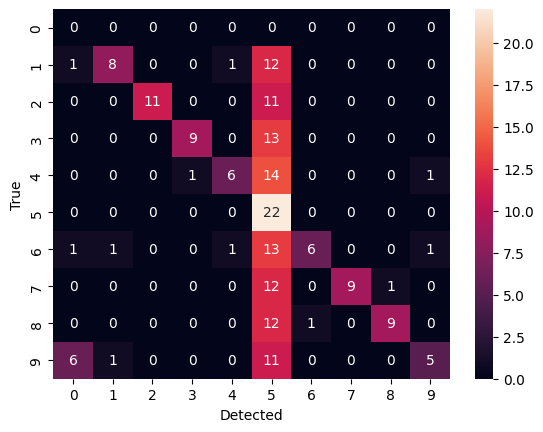

In [95]:
e.cm_plot()

In [96]:
e.metrics_calculation()
e.metrics_df()

metrics calculation


C:\Users\Utilisateur\Documents\Stage\TREC - Codage\trec-coding\evaluate.py:63: RuntimeWarning: invalid value encountered in scalar divide
  self.recall = [self.cm[i, i] / self.cm[i, :].sum() for i in range(0,10)]


0         1    2         3         4         5         6  \
Precision  0.0  0.800000  1.0  0.900000  0.750000  0.183333  0.857143   
Recall     NaN  0.363636  0.5  0.409091  0.272727  1.000000  0.260870   

                  7         8         9  
Precision  1.000000  0.900000  0.714286  
Recall     0.409091  0.409091  0.217391

<module 'matplotlib.pyplot' from 'C:\\Program Files\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

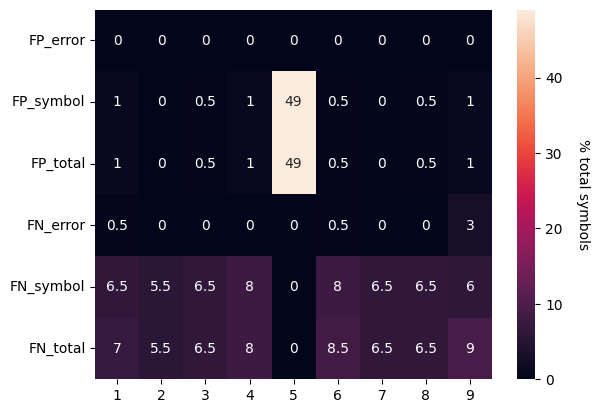

In [97]:
e.metrics_plot()

In [98]:
# Metrics for all labels :
print(f'False positive : {e.metrics_n.sum(axis=1)[2]}% of total symbols')
print(f'False negative : {e.metrics_n.sum(axis=1)[5]}% of total symbols')

False positive : 53.5% of total symbols
False negative : 57.5% of total symbols
